# Imports

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.cm as mplcm
import math
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Functions and Globals

In [2]:
def pca(gene_exp_datasets, experiments, age, labels, subplots_dims, figsize, savefile, by_experiment=True, 
        legend_loc="upper right", legend_size=10):
    import matplotlib.colors as colors
    sp_dim1 = subplots_dims[0]
    sp_dim2 = subplots_dims[1]
    pca = PCA(n_components = 2)
    fig, ax = plt.subplots(sp_dim1, sp_dim2, figsize=(figsize[0], figsize[1]))
    
    for idx, (gene_expression_data, experiments, age, labels) in enumerate(zip(gene_exp_datasets, experiments, age, labels)):
        df_2d = pd.DataFrame(pca.fit_transform(gene_expression_data))
        df_2d.index = gene_expression_data.index

        if (by_experiment):
            # Taken from https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
            def generate_colormap(number_of_distinct_colors: int = 80):
                if number_of_distinct_colors == 0:
                    number_of_distinct_colors = 80

                number_of_shades = 7
                number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

                # Create an array with uniformly drawn floats taken from <0, 1) partition
                linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

                # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
                #     but each saw tooth is slightly higher than the one before
                # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
                arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

                # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
                arr_by_shade_columns = arr_by_shade_rows.T

                # Keep number of saw teeth for later
                number_of_partitions = arr_by_shade_columns.shape[0]

                # Flatten the above matrix - join each row into single array
                nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

                # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
                initial_cm = hsv(nums_distributed_like_rising_saw)

                lower_partitions_half = number_of_partitions // 2
                upper_partitions_half = number_of_partitions - lower_partitions_half

                # Modify lower half in such way that colours towards beginning of partition are darker
                # First colours are affected more, colours closer to the middle are affected less
                lower_half = lower_partitions_half * number_of_shades
                for i in range(3):
                    initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

                # Modify second half in such way that colours towards end of partition are less intense and brighter
                # Colours closer to the middle are affected less, colours closer to the end are affected more
                for i in range(3):
                    for j in range(upper_partitions_half):
                        modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
                        modifier = j * modifier / upper_partitions_half
                        initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

                return ListedColormap(initial_cm)

            data_with_experiments = gene_expression_data.merge(experiments, left_index=True, right_index=True, how="left")
            num_colors = len(pd.unique(data_with_experiments.iloc[:, -1]))
            cm = generate_colormap(num_colors)
            cNorm  = colors.Normalize(vmin=0, vmax=num_colors)
            scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
            if len(gene_exp_datasets) > 1:
                if (sp_dim1 > 1):
                    ax[int(idx / sp_dim1)][idx % sp_dim2].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])
                else:
                    ax[idx].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])
            else:
                ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])
            for _, group in data_with_experiments.groupby('Bioproject'):
                if len(gene_exp_datasets) > 1:
                    if (sp_dim1 > 1):
                        ax[int(idx / sp_dim1)][idx % sp_dim2].scatter(df_2d.loc[group.index][0], df_2d.loc[group.index][1], s=150)
                    else:
                        ax[idx].scatter(df_2d.loc[group.index][0], df_2d.loc[group.index][1], s=150)
                else:
                    ax.scatter(df_2d.loc[group.index][0], df_2d.loc[group.index][1], s=150)
        else:
            df_2d = df_2d.merge(age, left_index=True, right_index=True, how='left')
            df_2d = df_2d.merge(labels, left_index=True, right_index=True, how='left')
            df_2d.columns = ['dim1', 'dim2', 'age', 'longevity']
            cm = plt.get_cmap('plasma')
            data_with_age = gene_expression_data.merge(age, left_index=True, right_index=True, how="left")
            data_with_age = data_with_age.merge(labels, left_index=True, right_index=True, how="left")
            age_groups = df_2d.groupby('age')
            ages = list(np.sort(age['age'].unique())[::-1])
            colors = cm(np.linspace(0, 1, len(ages)))
            color_index = 0
            while (ages):
                for name, group in age_groups:
                    if(name == ages[0]):
                        if (len(gene_exp_datasets) > 1):
                            if (sp_dim1 > 1):
                                ax[int(idx / sp_dim1)][idx % sp_dim2].plot(group[group['longevity'] == 0].dim1, group[group['longevity'] == 0].dim2, 
                                        label='long', marker='o', linestyle='',
                                       markersize=12, c=colors[color_index], markeredgecolor="black")
                                ax[int(idx / sp_dim1)][idx % sp_dim2].plot(group[group['longevity'] == 1].dim1, group[group['longevity'] == 1].dim2, 
                                        label='normal', marker='*', linestyle='',
                                       markersize=12, c=colors[color_index], markeredgecolor="black")
                                ax[int(idx / sp_dim1)][idx % sp_dim2].plot(group[group['longevity'] == 2].dim1, group[group['longevity'] == 2].dim2, 
                                        label='short', marker='^', linestyle='',
                                       markersize=12, c=colors[color_index], markeredgecolor="black")
                            else:
                                ax[idx].plot(group[group['longevity'] == 0].dim1, group[group['longevity'] == 0].dim2, 
                                    label='long', marker='o', linestyle='',
                                   markersize=12, c=colors[color_index], markeredgecolor="black")
                                ax[idx].plot(group[group['longevity'] == 1].dim1, group[group['longevity'] == 1].dim2, 
                                    label='normal', marker='*', linestyle='',
                                   markersize=12, c=colors[color_index], markeredgecolor="black")
                                ax[idx].plot(group[group['longevity'] == 2].dim1, group[group['longevity'] == 2].dim2, 
                                    label='short', marker='^', linestyle='',
                                    markersize=12, c=colors[color_index], markeredgecolor="black")
                        else:
                            ax.plot(group[group['longevity'] == 0].dim1, group[group['longevity'] == 0].dim2, 
                                    label='long', marker='o', linestyle='',
                                   markersize=12, c=colors[color_index], markeredgecolor="black")
                            ax.plot(group[group['longevity'] == 1].dim1, group[group['longevity'] == 1].dim2, 
                                    label='normal', marker='*', linestyle='',
                                   markersize=12, c=colors[color_index], markeredgecolor="black")
                            ax.plot(group[group['longevity'] == 2].dim1, group[group['longevity'] == 2].dim2, 
                                    label='short', marker='^', linestyle='',
                                   markersize=12, c=colors[color_index], markeredgecolor="black")

                        del ages[0]
                        color_index += 1
                        break

            ages = [str(age) + ' d/o' for age in list(np.sort(age['age'].unique())[::-1])]
            legend_elements = [Line2D([0], [0], marker='o', color='w', label='long',
                                      markerfacecolor='k', markersize=12, markeredgecolor="black"),
                               Line2D([0], [0], marker='*', color='w', label='normal',
                                      markerfacecolor='k', markersize=12, markeredgecolor="black"),
                               Line2D([0], [0], marker='^', color='w', label='short',
                                      markerfacecolor='k', markersize=12, markeredgecolor="black")]
            for i, color in enumerate(colors):
                age_patch = mpatches.Patch(color=colors[i], label=ages[i])
                legend_elements.append(age_patch)

            if (len(gene_exp_datasets) > 1):
                if (sp_dim1 > 1):
                    ax[int(idx / sp_dim1)][idx % sp_dim2].legend(handles=legend_elements, 
                                                                 loc=legend_loc,
                                                                 prop={'size': legend_size})
                else:
                    ax[idx].legend(handles=legend_elements, 
                                   loc=legend_loc,
                                   prop={'size': legend_size})
            else:
                ax.legend(handles=legend_elements, 
                          loc=legend_loc,
                          prop={'size': legend_size})
    ax.set_xlabel("PC1", fontsize = 22)
    ax.set_ylabel("PC2", fontsize = 22)
    ax.tick_params(axis='both', which='major', labelsize=19)
    fig.savefig(f'figures/{savefile}.png', bbox_inches='tight')

In [3]:
def create_similarity_matrix(gene_expression_data, savefile, subplots_dims, figsize):
    fig, ax = plt.subplots(subplots_dims[0], subplots_dims[1], figsize=(figsize[0], figsize[1]))
    sp_dim1 = subplots_dims[0]
    sp_dim2 = subplots_dims[1]
    for idx, gene_expression in enumerate(gene_expression_data):
        distance_matrix = euclidean_distances(gene_expression)
        distance_matrix = pd.DataFrame(distance_matrix)
        np.fill_diagonal(distance_matrix.values, distance_matrix.max().max())
        distance_matrix = -distance_matrix
        if (len(gene_expression_data) > 1):
            if (sp_dim1 > 1):
                ax[int(idx / sp_dim1)][idx % sp_dim2].imshow(distance_matrix, cmap='hot')
            else:
                ax[idx].imshow(distance_matrix, cmap='hot')
        else:
            ax.imshow(distance_matrix, cmap='hot')
    
    ax.set_xlabel("Sample", fontsize = 22)
    ax.set_ylabel("Sample", fontsize = 22)
    ax.tick_params(axis='both', which='major', labelsize=19)

    fig.savefig(f'figures/{savefile}.png', bbox_inches='tight', )

In [4]:
outliers = ['SRR10222650', 'SRR10222651', 'SRR10222652', 
            'SRR10222653', 'SRR10222654', 'SRR10222655', 
            'SRR10222656', 'SRR10222657', 'SRR10222658', 
            'SRR10222659', 'SRR10222660', 'SRR10222661']

In [5]:
os.makedirs('figures', exist_ok=True)

# Load Non Gene Expression Data

In [6]:
experiments = pd.read_csv('../common_datastore/sra_to_bioproject.csv')
experiments = experiments.set_index("Sample")
age = pd.read_csv("../common_datastore/age.csv")
age.set_index('Sample', inplace=True)
labels = pd.read_csv("../common_datastore/labels.csv")
labels.set_index('Sample', inplace=True)

# Dataset Stats

In [7]:
stats = labels[~labels.index.isin(outliers)].value_counts()
print(stats / sum(stats))

longevity
1            0.449146
0            0.358828
2            0.192026
dtype: float64


# PCA and Similarity Matrix

### GeTMM All Data

In [8]:
getmm_gene_expression_all_data = pd.read_csv('../common_datastore/getmm_gene_expression_all_data.csv')
getmm_gene_expression_all_data.columns = ['Sample'] + list(getmm_gene_expression_all_data.columns[1:])
getmm_gene_expression_all_data = getmm_gene_expression_all_data.set_index('Sample')

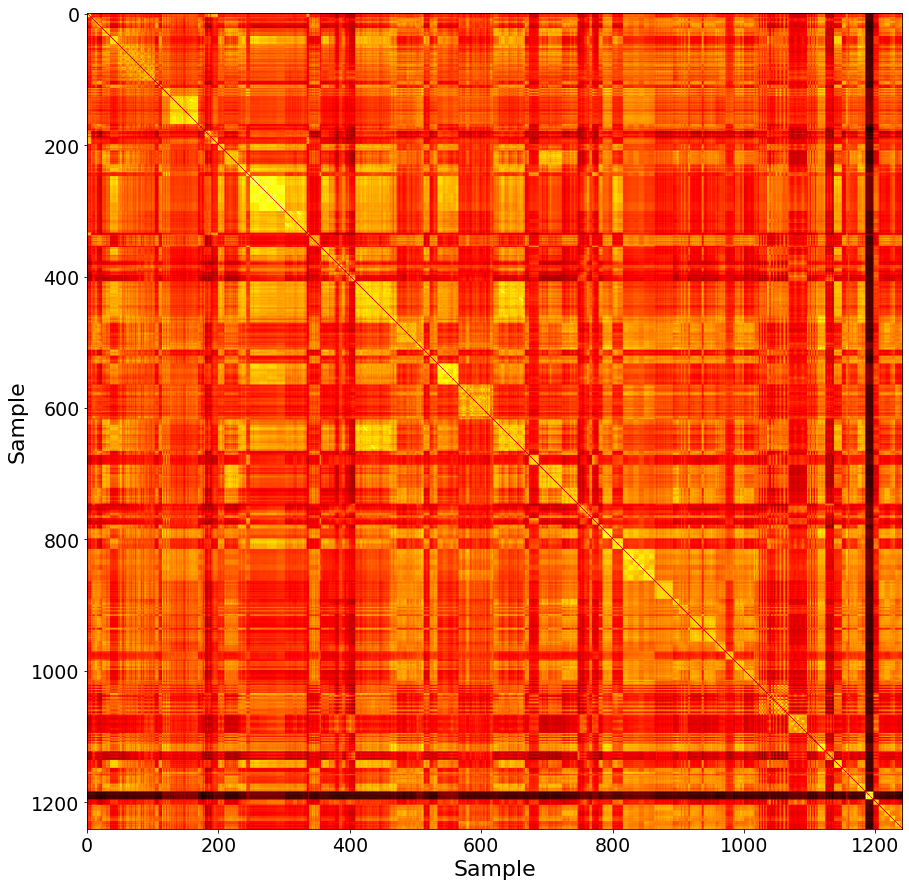

In [9]:
create_similarity_matrix([getmm_gene_expression_all_data], "getmm_all_data_similarity_matrix", (1,1), (15,15))

### GeTMM No outliers

In [102]:
getmm_gene_expression_no_outliers = pd.read_csv('../common_datastore/getmm_gene_expression_no_outliers.csv')
getmm_gene_expression_no_outliers.columns = ['Sample'] + list(getmm_gene_expression_no_outliers.columns[1:])
getmm_gene_expression_no_outliers = getmm_gene_expression_no_outliers.set_index('Sample')

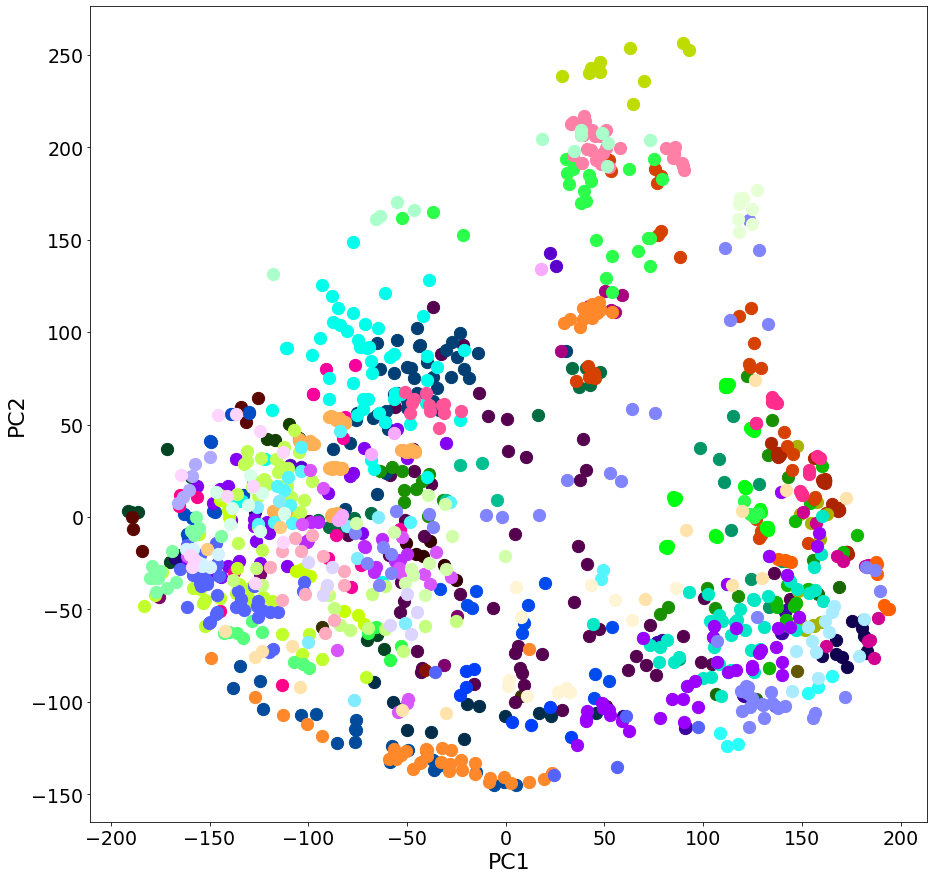

In [103]:
pca([getmm_gene_expression_no_outliers], [experiments], [age], [labels], 
    (1,1), (15,15), "pca_getmm_no_outliers_by_experiment", True)

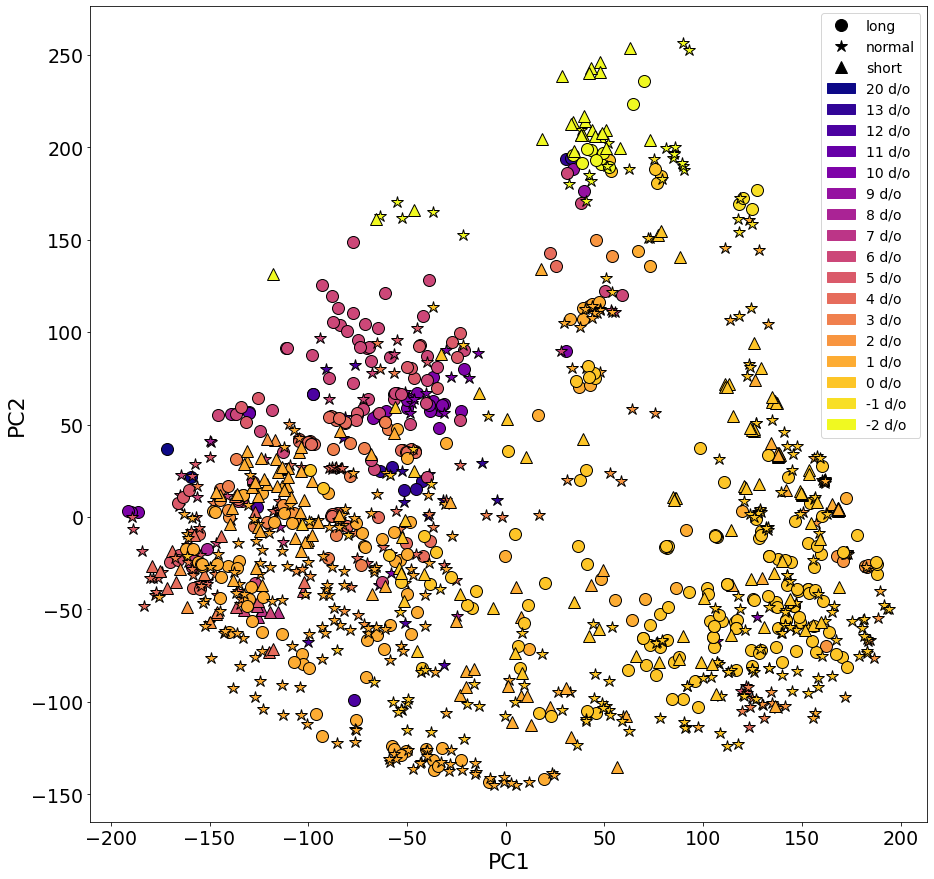

In [104]:
pca([getmm_gene_expression_no_outliers], [experiments], [age], [labels], (1,1), (15,15), 
    "pca_getmm_no_outliers_by_age", False, "upper right", 14)

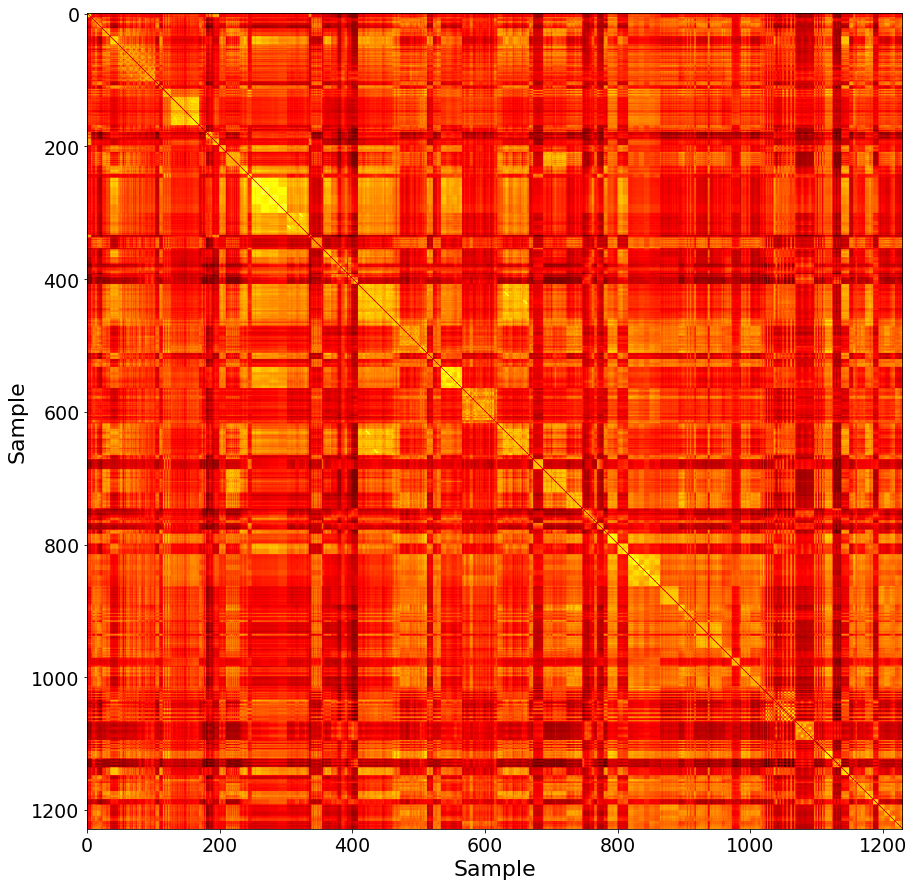

In [105]:
create_similarity_matrix([getmm_gene_expression_no_outliers], "getmm_no_outliers_similarity_matrix", (1,1), (15,15))

### GeTMM & Experiment Combat Seq 

In [106]:
combat_seq_getmm_ge_no_outliers_and_singles = pd.read_csv('../common_datastore/getmm_combat_seq_no_outliers_and_singles_gene_expression.csv')
combat_seq_getmm_ge_no_outliers_and_singles.columns = ['Sample'] + list(combat_seq_getmm_ge_no_outliers_and_singles.columns[1:])
combat_seq_getmm_ge_no_outliers_and_singles = combat_seq_getmm_ge_no_outliers_and_singles.set_index('Sample')

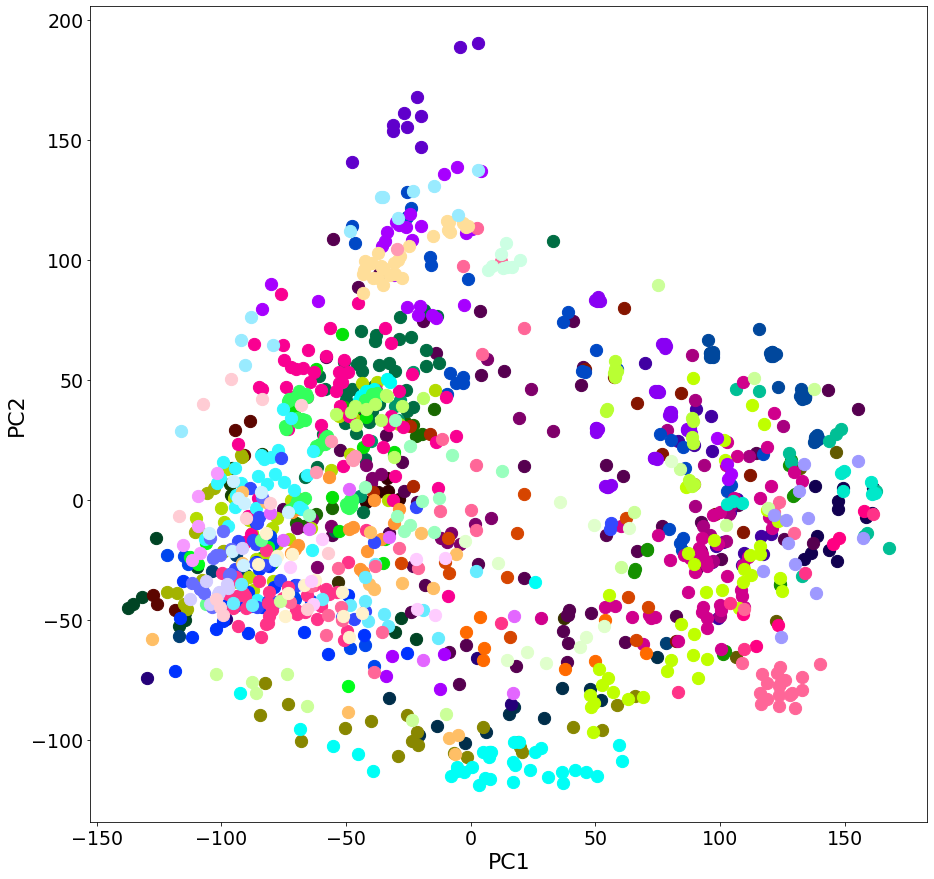

In [107]:
pca([combat_seq_getmm_ge_no_outliers_and_singles], [experiments], [age], [labels],
    (1,1), (15,15), "pca_combat_seq_getmm_no_outliers_and_singles_by_experiment", True)

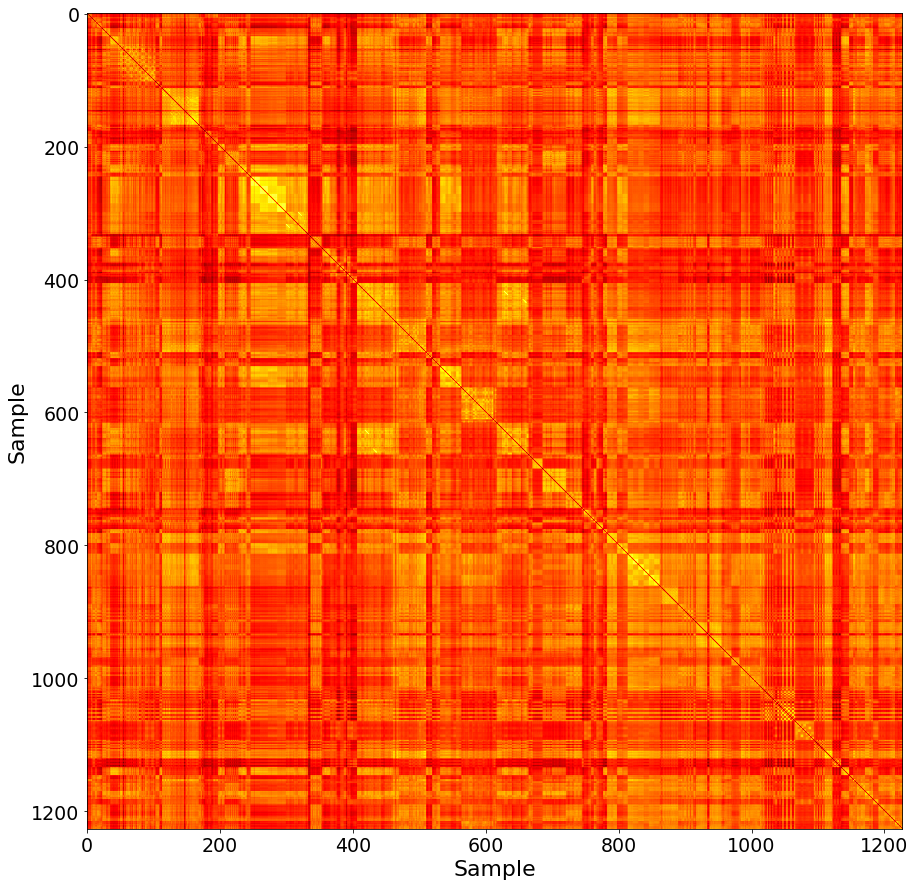

In [108]:
create_similarity_matrix([combat_seq_getmm_ge_no_outliers_and_singles], "combat_seq_getmm_no_outliers_and_singles_similarity_matrix", (1,1), (15,15))

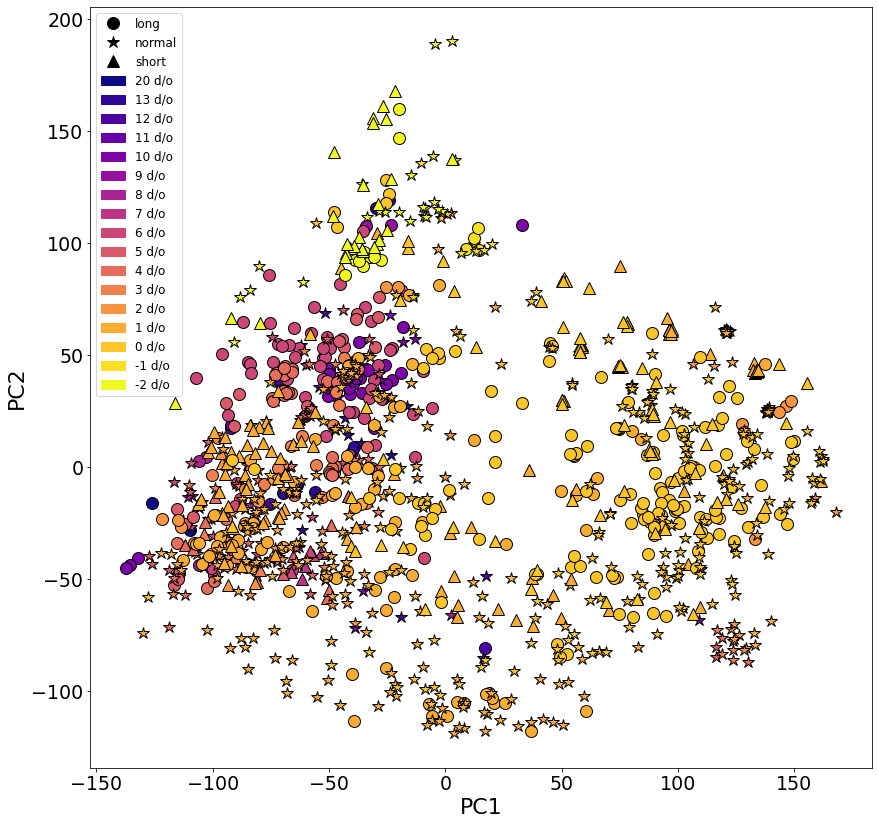

In [109]:
pca([combat_seq_getmm_ge_no_outliers_and_singles], [experiments], [age], [labels],
    (1,1), (14,14), "pca_by_age_combat_seq_getmm_no_singles_and_outliers", False, "upper left", 12)

### SAUCIE by experiment & GeTMM

In [29]:
# saucie_getmm_ge_no_outliers = pd.read_csv('../common_datastore/SAUCIE_getmm.csv')
# saucie_getmm_ge_no_outliers.columns = ['Sample'] + list(saucie_getmm_ge_no_outliers.columns[1:])
# saucie_getmm_ge_no_outliers = saucie_getmm_ge_no_outliers.set_index('Sample')

In [27]:
# create_similarity_matrix([saucie_getmm_ge_no_outliers], "saucie_getmm_no_outliers_similarity_matrix", (1,1), (30,30))

In [30]:
# pca([saucie_getmm_ge_no_outliers], [experiments], [age], [labels], (1,1), (15,15),
#     "pca_saucie_no_outliers_by_experiment", True)

### Combat-Seq by Age and GeTMM

In [110]:
age_adjusted_all_no_outliers_ged = pd.read_csv('../common_datastore/combat_seq_age_corrected_getmm_gene_expression_no_outliers.csv')
age_adjusted_all_no_outliers_ged.columns = ['Sample'] + list(age_adjusted_all_no_outliers_ged.columns[1:])
age_adjusted_all_no_outliers_ged = age_adjusted_all_no_outliers_ged.set_index('Sample')

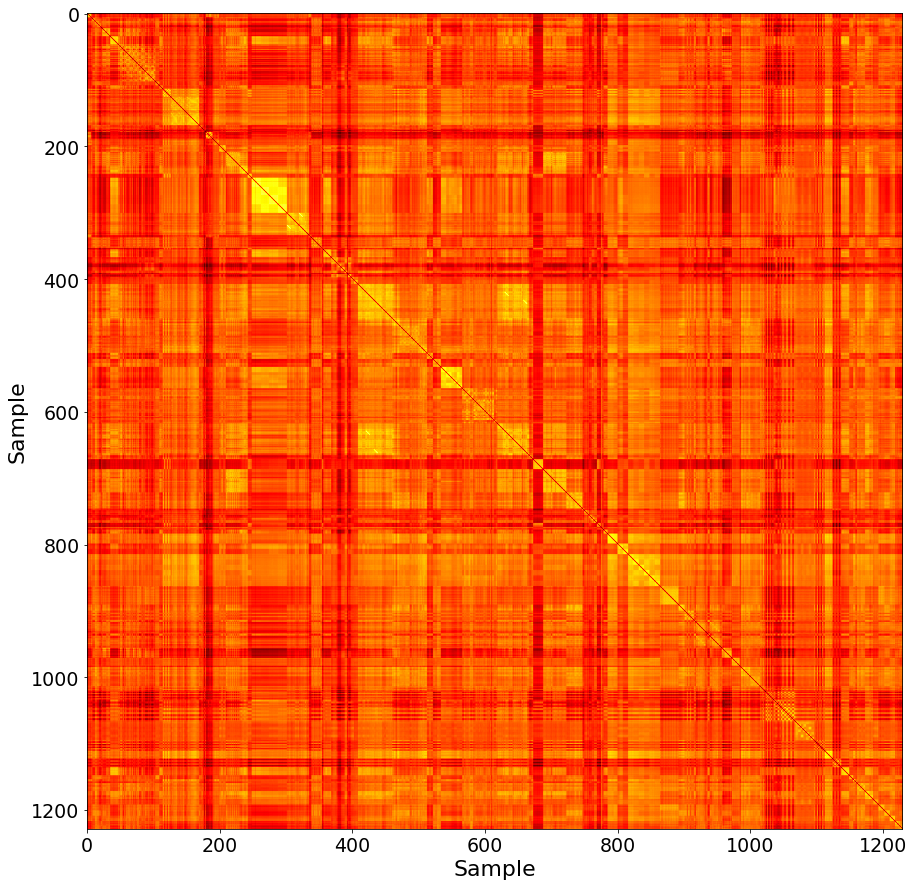

In [111]:
create_similarity_matrix([age_adjusted_all_no_outliers_ged], 
                         "combat_seq_age_corrected_all_getmm_no_ou1tliers_similarity_matrix",
                        (1,1), (15,15))

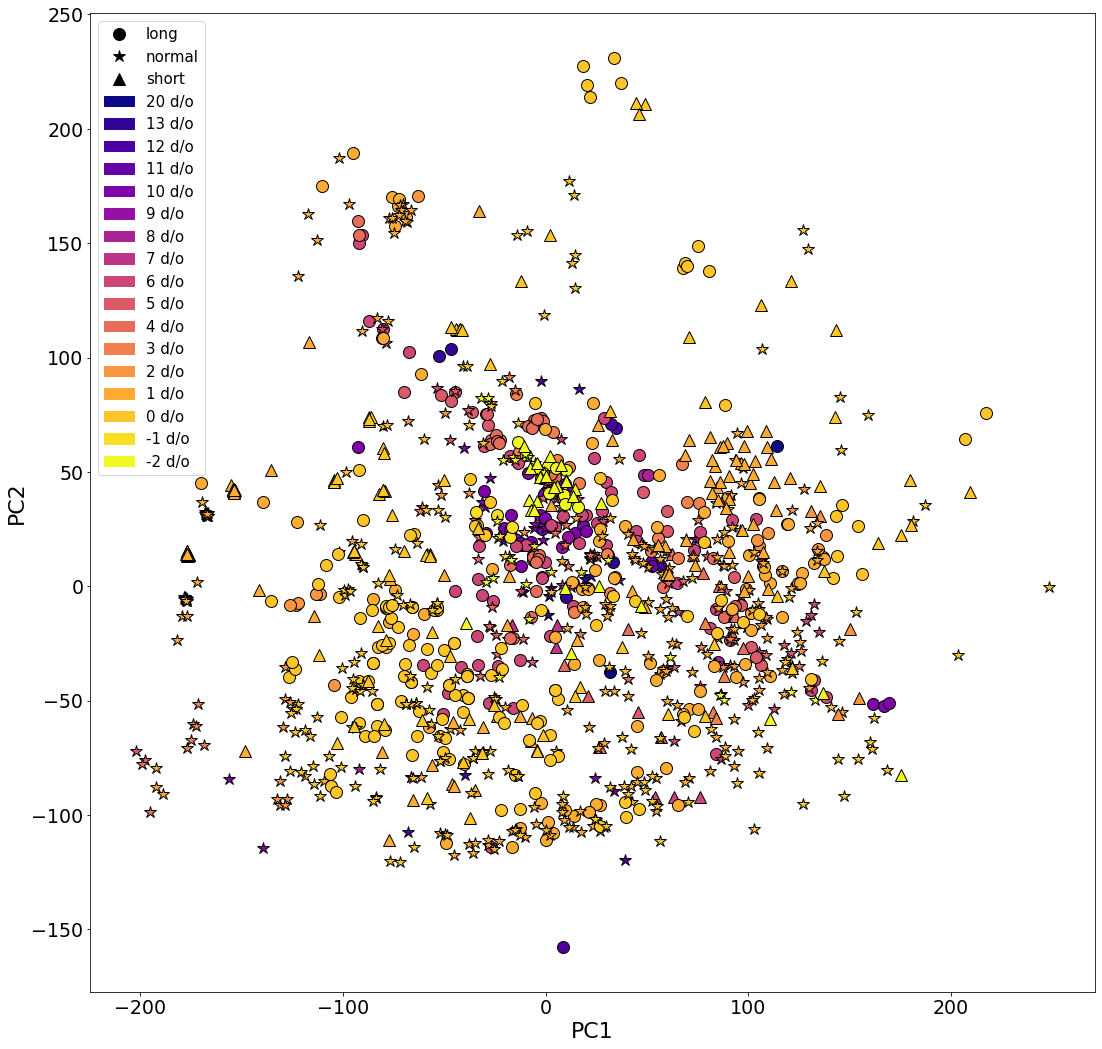

In [117]:
pca([age_adjusted_all_no_outliers_ged], [experiments], [age], [labels], (1,1), (18,18), 
    "combat_seq_age_corrected_all_getmm_no_outliers_pca_by_age", False, "upper left", 15)

### Filtered Data 

##### day 1 and older

In [21]:
day_1_and_older = pd.read_csv('../common_datastore/combat_seq_experiment_corrected_day_1_and_older_getmm_gene_expression_no_outliers.csv')
day_1_and_older.columns = ['Sample'] + list(day_1_and_older.columns[1:])
day_1_and_older = day_1_and_older.set_index('Sample')

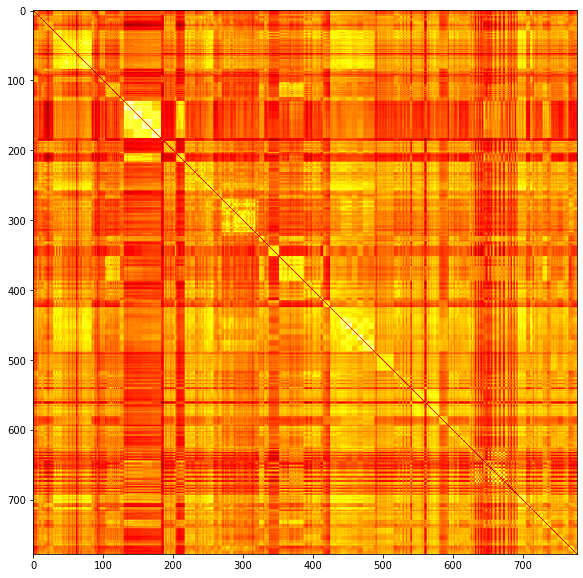

In [22]:
create_similarity_matrix([day_1_and_older], "day_1_and_older_similarity_matrix",
                        (1,1), (10,10))

<ipython-input-23-7667875b4bca>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pca([day_1_and_older], [experiments[age['age'] >= 1]],


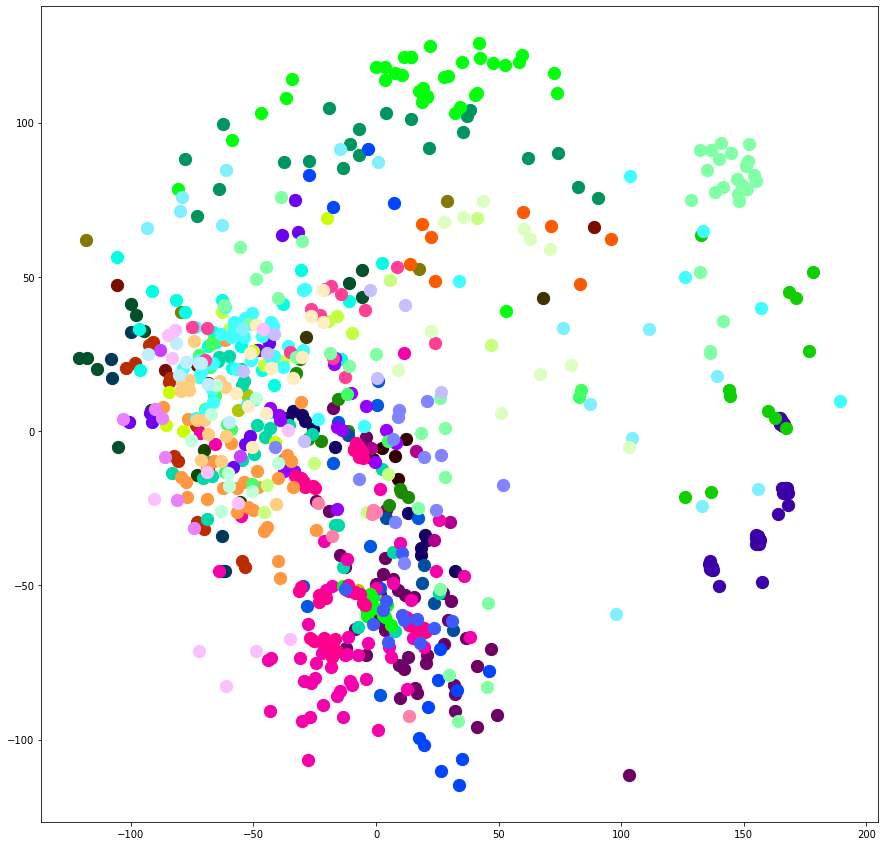

In [23]:
pca([day_1_and_older], [experiments[age['age'] >= 1]], 
    [age[age['age'] >= 1]], [labels[age['age'] >=1]], (1,1), (15,15), "day_1_and_older_pca_by_age", True)

#### L4 and younger

In [24]:
L4_and_younger = pd.read_csv('../common_datastore/combat_seq_experiment_corrected_L4_and_younger_getmm_gene_expression_no_outliers.csv')
L4_and_younger.columns = ['Sample'] + list(L4_and_younger.columns[1:])
L4_and_younger = L4_and_younger.set_index('Sample')

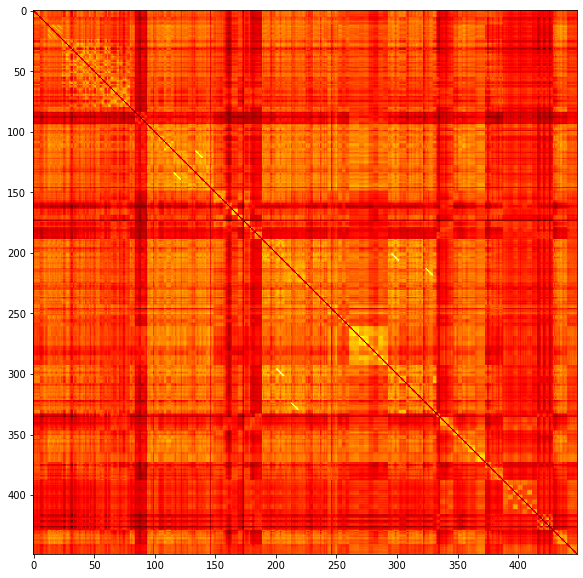

In [25]:
create_similarity_matrix([L4_and_younger], "L4_and_younger_similarity_matrix",
                        (1,1), (10,10))

<ipython-input-26-deba3a136622>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pca([L4_and_younger], [experiments[age['age'] < 1]],


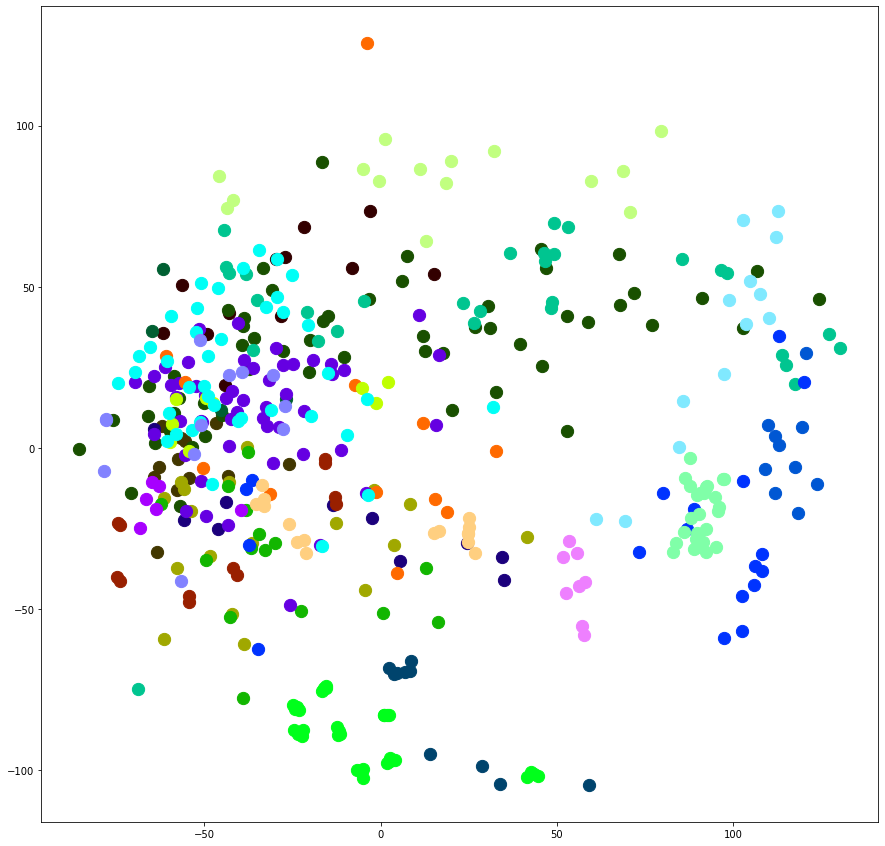

In [26]:
pca([L4_and_younger], [experiments[age['age'] < 1]], 
    [age[age['age'] < 1]], [labels[age['age'] < 1]], (1,1), (15,15), "L4_and_younger_pca_by_age", True)

#### Both

<ipython-input-27-a3de95e150b9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  [experiments[age['age'] >= 1], experiments[age['age'] < 1]],


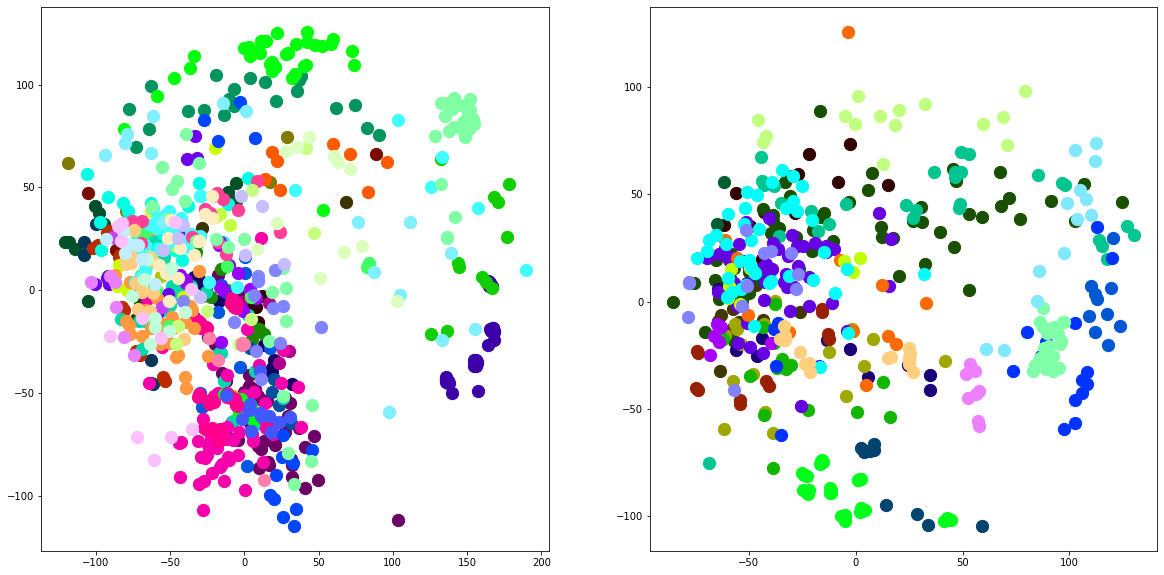

In [27]:
pca([day_1_and_older, L4_and_younger], 
    [experiments[age['age'] >= 1], experiments[age['age'] < 1]], 
    [age[age['age'] >= 1], age[age['age'] < 1]], 
    [labels[age['age'] >= 1], labels[age['age'] < 1]], 
    (1,2), (20,10), "combined_pca_plots", True)

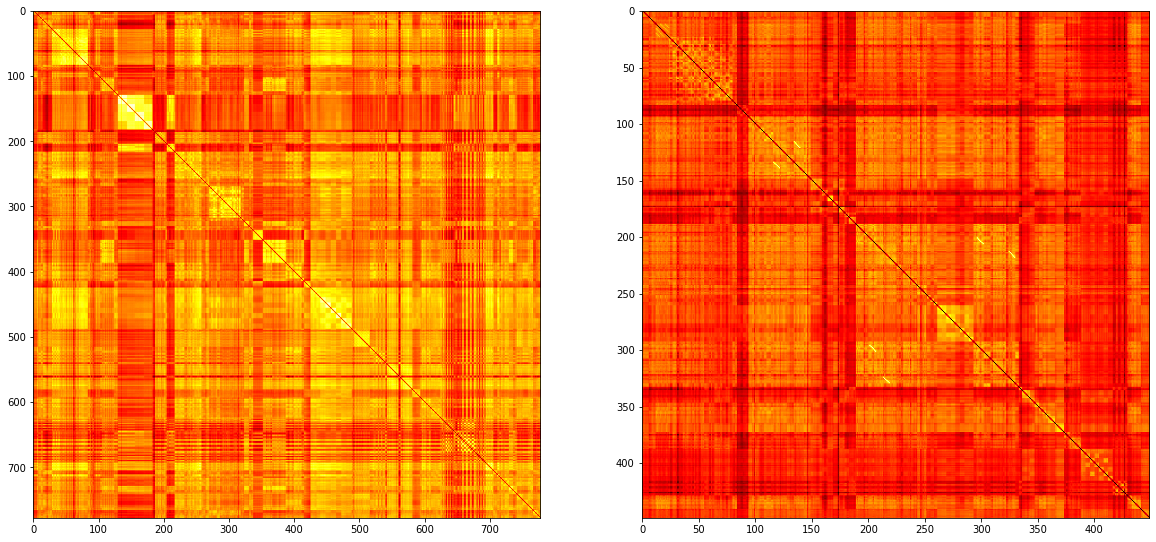

In [28]:
create_similarity_matrix([day_1_and_older, 
                          L4_and_younger], "combined_similarity_matrices",
                        (1,2), (20,20))

### GeTMM and double Combat-Seq by age and experiment

In [29]:
combat_seq_double_getmm_ge_no_outliers_and_singles = pd.read_csv('../common_datastore/combat_seq_experiment_and_age_corrected_getmm_gene_expression_no_outliers.csv')
combat_seq_double_getmm_ge_no_outliers_and_singles.columns = ['Sample'] + list(combat_seq_double_getmm_ge_no_outliers_and_singles.columns[1:])
combat_seq_double_getmm_ge_no_outliers_and_singles = combat_seq_double_getmm_ge_no_outliers_and_singles.set_index('Sample')

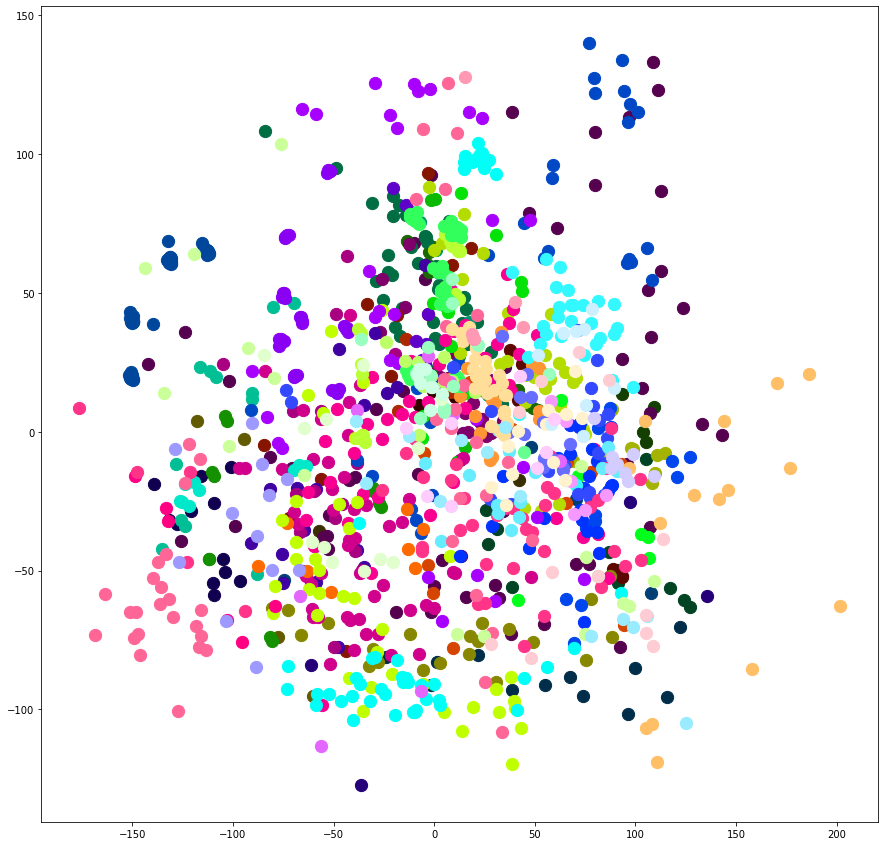

In [30]:
pca([combat_seq_double_getmm_ge_no_outliers_and_singles], 
    [experiments], [age], [labels], (1,1), (15,15), 
    "pca_by_experiment_getmm_double_combat_seq", True)

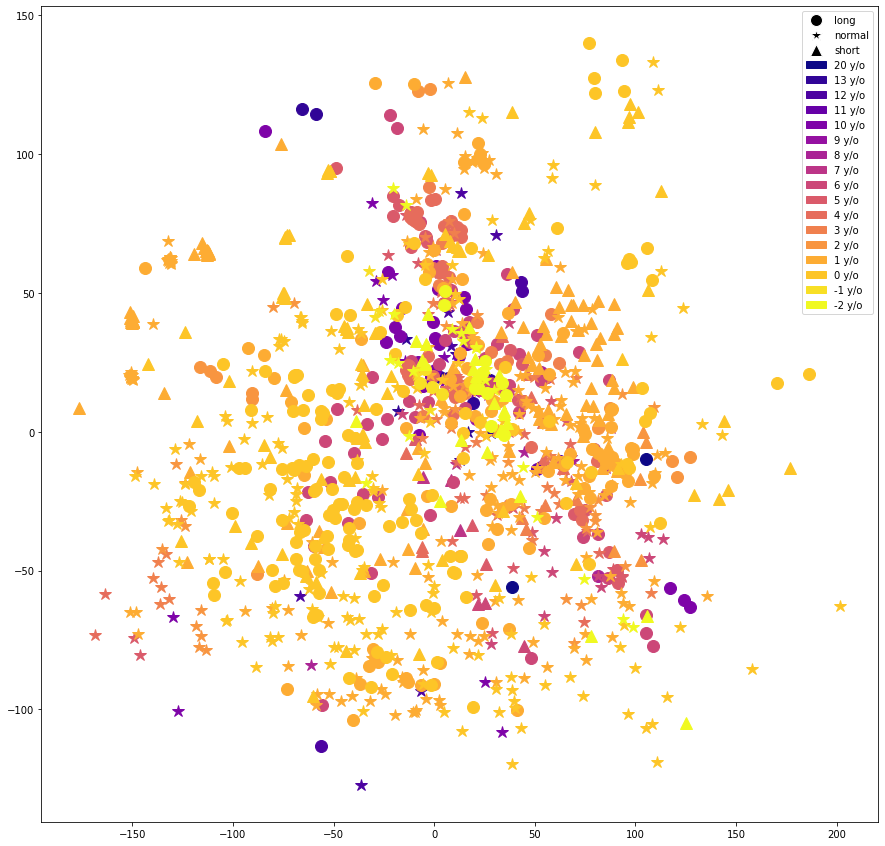

In [31]:
pca([combat_seq_double_getmm_ge_no_outliers_and_singles], [experiments], [age], [labels],
    (1,1), (15,15), "pca_by_age_double_combat_seq_getmm", False)

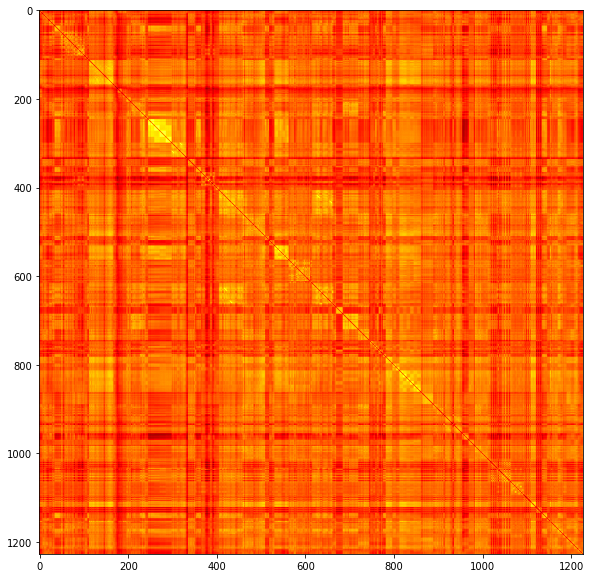

In [32]:
create_similarity_matrix([combat_seq_double_getmm_ge_no_outliers_and_singles], 
                         "double_combat_seq_similarity_matrix",
                        (1,1), (10,10))

### GO filtered 

In [33]:
combat_seq_getmm_GO_filtered_gene_expression_no_singles = pd.read_csv('../common_datastore/combat_seq_getmm_GO_filtered_gene_expression_no_singles_and_outliers.csv')
combat_seq_getmm_GO_filtered_gene_expression_no_singles.columns = ['Sample'] + list(combat_seq_getmm_GO_filtered_gene_expression_no_singles.columns[1:])
combat_seq_getmm_GO_filtered_gene_expression_no_singles = combat_seq_getmm_GO_filtered_gene_expression_no_singles.set_index('Sample')

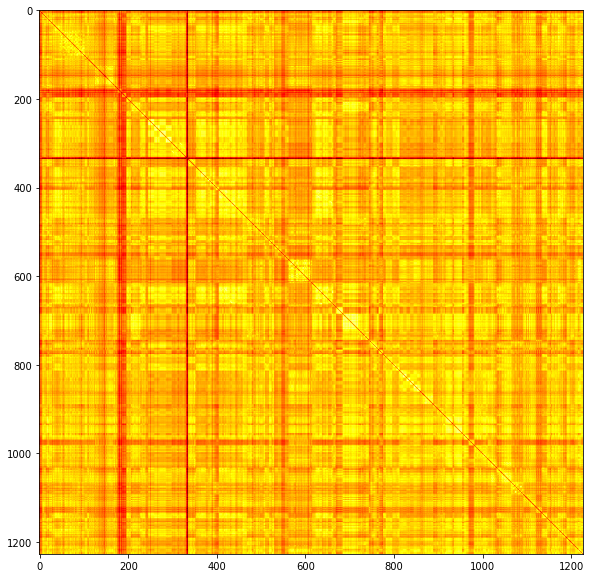

In [34]:
create_similarity_matrix([combat_seq_getmm_GO_filtered_gene_expression_no_singles], "combat_seq_getmm_GO_filtered_gene_expression_no_singles_similarity_matrix",
                        (1,1), (10,10))

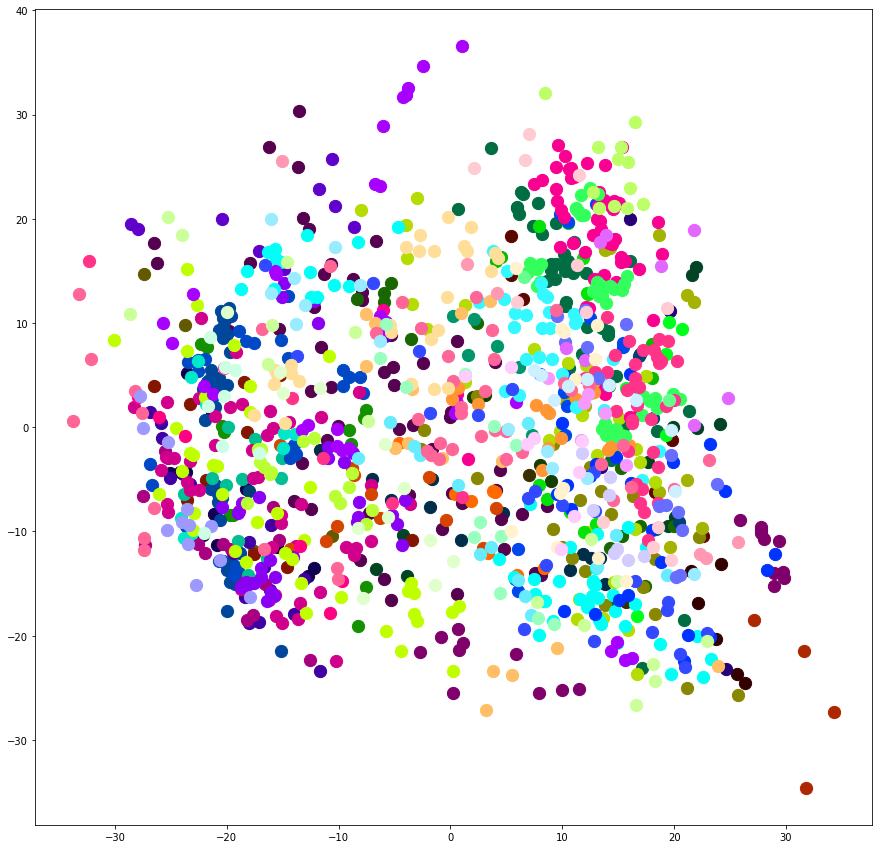

In [35]:
pca([combat_seq_getmm_GO_filtered_gene_expression_no_singles], [experiments], [age], 
    [labels], (1,1), (15,15), "pca_combat_seq_getmm_GO_filtered_gene_expression_no_singles", True)